In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/My Drive/Siamese/Localization'

/content/drive/My Drive/Siamese/Localization


In [3]:
import sys
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')
sys.path.insert(0, '..')

In [4]:
!pip install torchaudio
!pip install pyroomacoustics==0.3.1
!pip install cookiecutter

In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 10

torch.backends.cudnn.deterministic = True
B = 8

WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
NUM_WORKERS = 4

NUM_CLASSES = 10

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

trainset = IdentificationDataset(DATASET_PATH, 
                                 NUM_CLASSES,
                                 train=True, 
                                 transform=transforms,
                                 lenght=1,
                                 return_type=ReturnType.STANDARD)
trainsetloader = torch.utils.data.DataLoader(trainset, 
                                             batch_size=B, 
                                             num_workers=NUM_WORKERS, 
                                             shuffle=True)

testset = IdentificationDataset(DATASET_PATH, 
                                NUM_CLASSES,
                                train=False, 
                                transform=transforms,
                                lenght=1,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=B, 
                                            num_workers=NUM_WORKERS)

print("lenght train loader ", len(trainsetloader))
print("lenght test loader ", len(testsetloader))


sample lenght  1
sample lenght  1
lenght train loader  129
lenght test loader  144


In [8]:
from LocateEncoder import LocateEncoder

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = LocateEncoder(final_size=64)

net.to(DEVICE)

LocateEncoder(
  (conv1): Conv1DBlock(
    (conv): Conv1d(1, 16, kernel_size=(5,), stride=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv1DBlock(
    (conv): Conv1d(16, 64, kernel_size=(5,), stride=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv1DBlock(
    (conv1): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Conv1DBlock(
    (conv1): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (acti): ReLU()
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Conv1DBlock(
    (conv1): Conv1d(64, 16, kernel

In [9]:
import numpy as np
from Room import Room

optimizer = optim.SGD(net.parameters(), LR_INIT, MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

max_accuracy = 0
test_accuracy = []
train_accuracy = []

train_losses = []
test_losses = []

for epoch_num in range(EPOCH_NUM):
    train_loss = 0
    test_loss = 0
    print("*** Epoch ", epoch_num, " ***")
    lr_scheduler.step()
    
    # train
    print("*** Train ***")
    net.train()

    accuracy = 0
    nb_test = 0
    
    for iter_num, (_, samples) in tqdm(enumerate(trainsetloader)):
      # Create a room
      room = Room()
      # Add samples in room
      for sample in samples:
        room.addsource(sample)
      # Get mics
      sample1, sample2 = room()
      sample1 = sample1.to(DEVICE)
      sample2 = sample2.to(DEVICE)
      optimizer.zero_grad()
      # Send mics to network
      results, loss = net(sample1, sample2)
      # Learn
      loss.backward()
      # Store loss and accuracy
      train_loss += loss.item()
      accuracy += results.mean()
      optimizer.step()

    train_loss /= len(trainsetloader)
    print("Train loss ", train_loss)
    train_losses.append(train_loss)
    accuracy /= len(trainsetloader)
    print("Train accuracy ", accuracy)
    train_accuracy.append(accuracy)
    
    # test
    net.eval()
    print("*** Test ***")
    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (_, samples) in tqdm(enumerate(testsetloader)):
      # Create a room
      room = Room()
      # Add samples in room
      for sample in samples:
        room.addsource(sample)
      # Get mics
      sample1, sample2 = room()
      sample1 = sample1.to(DEVICE)
      sample2 = sample2.to(DEVICE)
      # Send mics to network
      results, loss = net(sample1, sample2)
      # Store loss and accuracy
      test_loss += loss.item()
      accuracy += results.mean()

    test_loss /= len(testsetloader)
    print("Test loss ", test_loss)
    test_losses.append(test_loss)
    accuracy /= len(testsetloader)
    print("Test accuracy ", accuracy)
    test_accuracy.append(accuracy)

    if accuracy > max_accuracy:
      net.store_encoder()



*** Epoch  0  ***
*** Train ***


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
129it [01:05,  1.97it/s]

Train loss  68.1579015458277
Train accuracy  tensor(0.9505, device='cuda:0')
*** Test ***



144it [00:32,  4.49it/s]

Test loss  50.229028287861084
Test accuracy  tensor(0.9609, device='cuda:0')
*** Epoch  1  ***
*** Train ***



129it [01:06,  1.95it/s]

Train loss  42.722592110781704
Train accuracy  tensor(0.9665, device='cuda:0')
*** Test ***



144it [00:32,  4.40it/s]


Test loss  45.29420015050305
Test accuracy  tensor(0.9672, device='cuda:0')
*** Epoch  2  ***
*** Train ***


129it [01:06,  1.95it/s]

Train loss  38.90891813862231
Train accuracy  tensor(0.9694, device='cuda:0')
*** Test ***



144it [00:32,  4.42it/s]


Test loss  35.26857088837359
Test accuracy  tensor(0.9720, device='cuda:0')
*** Epoch  3  ***
*** Train ***


129it [01:05,  1.96it/s]

Train loss  34.229429675627124
Train accuracy  tensor(0.9727, device='cuda:0')
*** Test ***



144it [00:32,  4.44it/s]


Test loss  32.98830056852765
Test accuracy  tensor(0.9744, device='cuda:0')
*** Epoch  4  ***
*** Train ***


129it [01:06,  1.95it/s]

Train loss  31.233777630698775
Train accuracy  tensor(0.9741, device='cuda:0')
*** Test ***



144it [00:32,  4.39it/s]


Test loss  30.390497233718634
Test accuracy  tensor(0.9760, device='cuda:0')
*** Epoch  5  ***
*** Train ***


129it [01:06,  1.95it/s]

Train loss  31.542956965838293
Train accuracy  tensor(0.9747, device='cuda:0')
*** Test ***



144it [00:32,  4.42it/s]


Test loss  30.86113188167413
Test accuracy  tensor(0.9758, device='cuda:0')
*** Epoch  6  ***
*** Train ***


129it [01:06,  1.95it/s]

Train loss  29.482163453286933
Train accuracy  tensor(0.9763, device='cuda:0')
*** Test ***



144it [00:32,  4.41it/s]


Test loss  29.884892337852055
Test accuracy  tensor(0.9751, device='cuda:0')
*** Epoch  7  ***
*** Train ***


129it [01:06,  1.95it/s]

Train loss  31.58043183467185
Train accuracy  tensor(0.9739, device='cuda:0')
*** Test ***



144it [00:32,  4.40it/s]


Test loss  28.214922512571018
Test accuracy  tensor(0.9773, device='cuda:0')
*** Epoch  8  ***
*** Train ***


129it [01:06,  1.95it/s]

Train loss  27.476902581462564
Train accuracy  tensor(0.9777, device='cuda:0')
*** Test ***



144it [00:32,  4.42it/s]


Test loss  31.04558949669202
Test accuracy  tensor(0.9747, device='cuda:0')
*** Epoch  9  ***
*** Train ***


129it [01:05,  1.96it/s]

Train loss  30.218824214713518
Train accuracy  tensor(0.9756, device='cuda:0')
*** Test ***



144it [00:32,  4.47it/s]


Test loss  27.184845291905933
Test accuracy  tensor(0.9774, device='cuda:0')


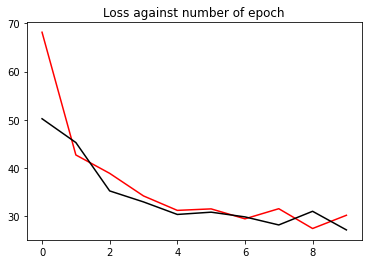

In [10]:
import matplotlib.pyplot as plt

plt.title("Loss against number of epoch")
plt.plot([i for i in range(EPOCH_NUM)], train_losses , label='Train loss', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_losses , label='Test loss', color='black')


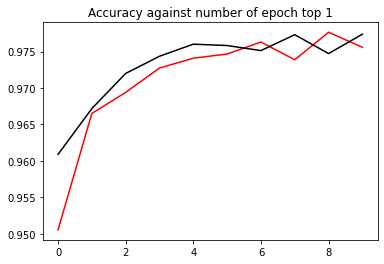

In [11]:
plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], train_accuracy , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_accuracy , label='test 1', color='black')
